In [1]:
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset
import cv2
import pandas as pd
from google.colab import drive
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pickle as pkl
import shutil
from random import randint, shuffle
from sklearn.model_selection import train_test_split
from collections import Counter
import datetime
import tqdm
import yaml

% matplotlib inline
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip / content / drive / MyDrive / Baggage / positive-Annotation.zip

os.mkdir('dataset')
!unzip / content / drive / MyDrive / Baggage / positive_JPEGImage.zip -d / content / dataset

os.mkdir('dataset_negative')
!unzip / content / drive / MyDrive / Baggage / negative_JPEGImage.zip -d / content / dataset_negative

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/dataset_negative/N0005734.jpg  
  inflating: /content/dataset_negative/N0005735.jpg  
  inflating: /content/dataset_negative/N0005736.jpg  
  inflating: /content/dataset_negative/N0005737.jpg  
  inflating: /content/dataset_negative/N0005738.jpg  
  inflating: /content/dataset_negative/N0005739.jpg  
  inflating: /content/dataset_negative/N0005740.jpg  
  inflating: /content/dataset_negative/N0005741.jpg  
  inflating: /content/dataset_negative/N0005742.jpg  
  inflating: /content/dataset_negative/N0005743.jpg  
  inflating: /content/dataset_negative/N0005744.jpg  
  inflating: /content/dataset_negative/N0005745.jpg  
  inflating: /content/dataset_negative/N0005746.jpg  
  inflating: /content/dataset_negative/N0005747.jpg  
  inflating: /content/dataset_negative/N0005748.jpg  
  inflating: /content/dataset_negative/N0005749.jpg  
  inflating: /content/dataset_negative/N0005750.jpg  
  inflating: /

# Анализ данных

## Получение pandas DataFrame'а из xml файлов

In [3]:
images = os.listdir('dataset')
print(f'Количество всех изображений: {len(images)} шт.')

positive_images = []
negative_images = []
uncertain_files = []
for img in images:
    if img.startswith('P'):
        positive_images.append(img)
    elif img.startswith('N'):
        negative_images.append(img)
    else:
        uncertain_files.append(img)

print(f'Количество позитивных изображений: {len(positive_images)} шт., \
Количество негативных изображений: {len(negative_images)} шт., \
Количество неопределенных файлов: {len(uncertain_files)} шт.')

Количество всех изображений: 8827 шт.
Количество позитивных изображений: 8827 шт., Количество негативных изображений: 0 шт., Количество неопределенных файлов: 0 шт.


In [5]:
def df_positive_images():
    no_object_xml_files = []
    no_size_xml_files = []
    wrong_object_xml_files = []
    size_mismatch = []
    info_all_imgs = []

    for img in positive_images:
        xml_path = f'/content/Annotation/{img[:-4]}.xml'
        tree = ET.parse(xml_path)
        root = tree.getroot()

        if root.find('size') is None:
            no_size_xml_files.append(img)
            img_path = f'/content/dataset/{img}'
            img = cv2.imread(img_path)
            height, width, depth = img.shape
        else:
            width = int(root.find('size').find('width').text)
            height = int(root.find('size').find('height').text)
            depth = int(root.find('size').find('depth').text)
            if (width != int(root.find('size').find('width').text) or
                    height != int(root.find('size').find('height').text) or
                    depth != int(root.find('size').find('depth').text)):
                size_mismatch.append(img)

        if root.findall('object') != []:
            for member in root.findall('object'):
                if member.find('bndbox') is None or member.find('name') is None:
                    wrong_object_xml_files.append(img)
                    continue
                obj = [img,
                       int(float(member.find('bndbox').find('xmin').text)),
                       int(float(member.find('bndbox').find('ymin').text)),
                       int(float(member.find('bndbox').find('xmax').text)),
                       int(float(member.find('bndbox').find('ymax').text)),
                       ('Gun', 'Knife', 'Wrench', 'Pliers', 'Scissors').index(member.find('name').text),
                       member.find('name').text,
                       height, width, depth]
                info_all_imgs.append(obj)
        else:
            no_object_xml_files.append(img)

    positive_img_df = pd.DataFrame(
        columns=['images', 'xmin', 'ymin', 'xmax', 'ymax', 'class',
                 'name_class', 'width', 'height', 'depth'],
        data=info_all_imgs)

    return (positive_img_df, no_object_xml_files, no_size_xml_files,
            wrong_object_xml_files, size_mismatch)


(positive_img_df, no_object_xml_files, no_size_xml_files,
 wrong_object_xml_files, size_mismatch) = df_positive_images()
positive_img_df.head()

,images,xmin,ymin,xmax,ymax,class,name_class,width,height,depth
0,P00795.jpg,85,219,329,324,1,Knife,513,582,3
1,P00795.jpg,18,133,430,389,1,Knife,513,582,3
2,P00795.jpg,332,118,501,233,0,Gun,513,582,3
3,P00795.jpg,303,93,523,193,3,Pliers,513,582,3
4,P00795.jpg,278,91,491,264,2,Wrench,513,582,3


In [6]:
positive_img_df.name_class.unique()

array(['Knife', 'Gun', 'Pliers', 'Wrench', 'Scissors'], dtype=object)

### Проверка датасета

In [7]:
print(f'Картинки, к которым нет bounding boxes: {no_object_xml_files}.\n\
Их количество: {len(no_object_xml_files)} шт.')

print(f'Картинки, к которым нет размеров: {no_size_xml_files}.\n\
Их количество: {len(no_size_xml_files)} шт.')

print(f'Картинки, у которых есть пустые поля object: {wrong_object_xml_files}.\n\
Их количество: {len(wrong_object_xml_files)} шт.')

Картинки, к которым нет bounding boxes: ['P06733.jpg', 'P05537.jpg', 'P06239.jpg', 'P05592.jpg', 'P05110.jpg', 'P06732.jpg', 'P08009.jpg', 'P08007.jpg', 'P06846.jpg', 'P06240.jpg', 'P05535.jpg', 'P08341.jpg', 'P08342.jpg', 'P08010.jpg', 'P07218.jpg', 'P05538.jpg', 'P05111.jpg', 'P08008.jpg', 'P05536.jpg', 'P07217.jpg', 'P07219.jpg'].
Их количество: 21 шт.
Картинки, к которым нет размеров: [].
Их количество: 0 шт.
Картинки, у которых есть пустые поля object: ['P08493.jpg', 'P06012.jpg', 'P07353.jpg', 'P08079.jpg', 'P07458.jpg', 'P04029.jpg', 'P08077.jpg', 'P06029.jpg', 'P05294.jpg', 'P04979.jpg', 'P07355.jpg', 'P08083.jpg', 'P06972.jpg', 'P08081.jpg'].
Их количество: 14 шт.


## Посмотрим на некоторые изображения

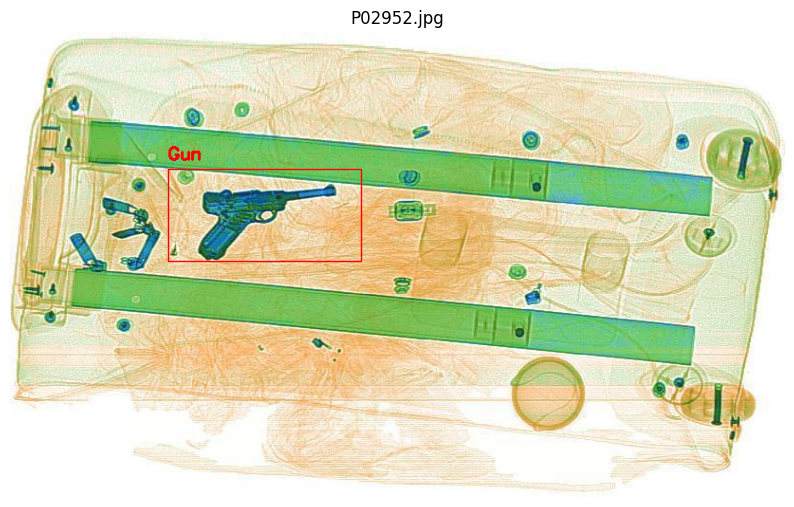

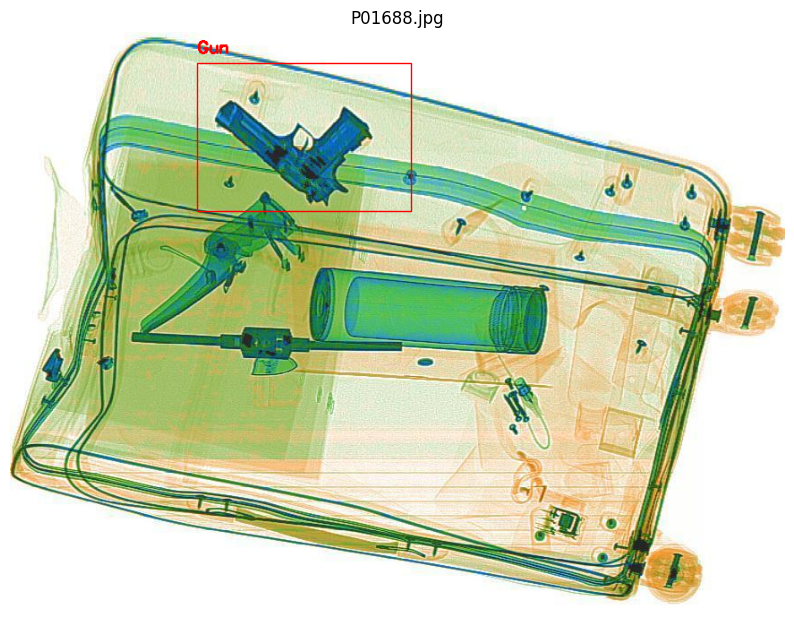

In [8]:
def draw_img_with_box(df, df_index):
    df['bboxes_name'] = df[['xmin', 'ymin', 'xmax', 'ymax',
                            'name_class']].apply(list, axis=1)
    df = df.drop(columns=['xmin', 'ymin', 'xmax', 'ymax', 'class', 'name_class',
                          'width', 'height', 'depth']).groupby('images',
                                                               as_index=False).agg(list)
    img = cv2.imread(f"/content/dataset/{df.loc[df_index, 'images']}")
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    fig, ax = plt.subplots(figsize=(10, 10))
    boxes_name = df.loc[df_index, 'bboxes_name']
    for bbox in boxes_name:
        rect = patches.Rectangle((int(bbox[0]), int(bbox[1])),
                                 int(bbox[2]) - int(bbox[0]),
                                 int(bbox[3]) - int(bbox[1]),
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        cv2.putText(img, bbox[4], (int(bbox[0]), int(bbox[1]) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    ax.imshow(img)
    plt.title(df.loc[df_index, 'images'])
    ax.axis('off')
    plt.show()


for _ in range(2):
    draw_img_with_box(positive_img_df, randint(0, len(images)))

## Нахождение различных статистик для ширины и высоты

In [9]:
positive_img_df.info()

print(f'Минимум ширины: {int(positive_img_df.width.min())}.\n\
Минимум высоты: {int(positive_img_df.height.min())}.\n\
Максимум ширины: {int(positive_img_df.width.max())}.\n\
Максимум высоты: {int(positive_img_df.height.max())}.\n\
Медиана ширины: {int(positive_img_df.width.median())}.\n\
Медиана высоты: {int(positive_img_df.height.median())}.\n\
Среднее ширины: {int(positive_img_df.width.mean())}.\n\
Среднее высоты: {int(positive_img_df.height.mean())}.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17491 entries, 0 to 17490
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   images       17491 non-null  object
 1   xmin         17491 non-null  int64 
 2   ymin         17491 non-null  int64 
 3   xmax         17491 non-null  int64 
 4   ymax         17491 non-null  int64 
 5   class        17491 non-null  int64 
 6   name_class   17491 non-null  object
 7   width        17491 non-null  int64 
 8   height       17491 non-null  int64 
 9   depth        17491 non-null  int64 
 10  bboxes_name  17491 non-null  object
dtypes: int64(8), object(3)
memory usage: 1.5+ MB
Минимум ширины: 144.
Минимум высоты: 151.
Максимум ширины: 1035.
Максимум высоты: 1536.
Медиана ширины: 577.
Медиана высоты: 654.
Среднее ширины: 582.
Среднее высоты: 680.


### Распределения

#### Распределение по количеству различных значений ширины

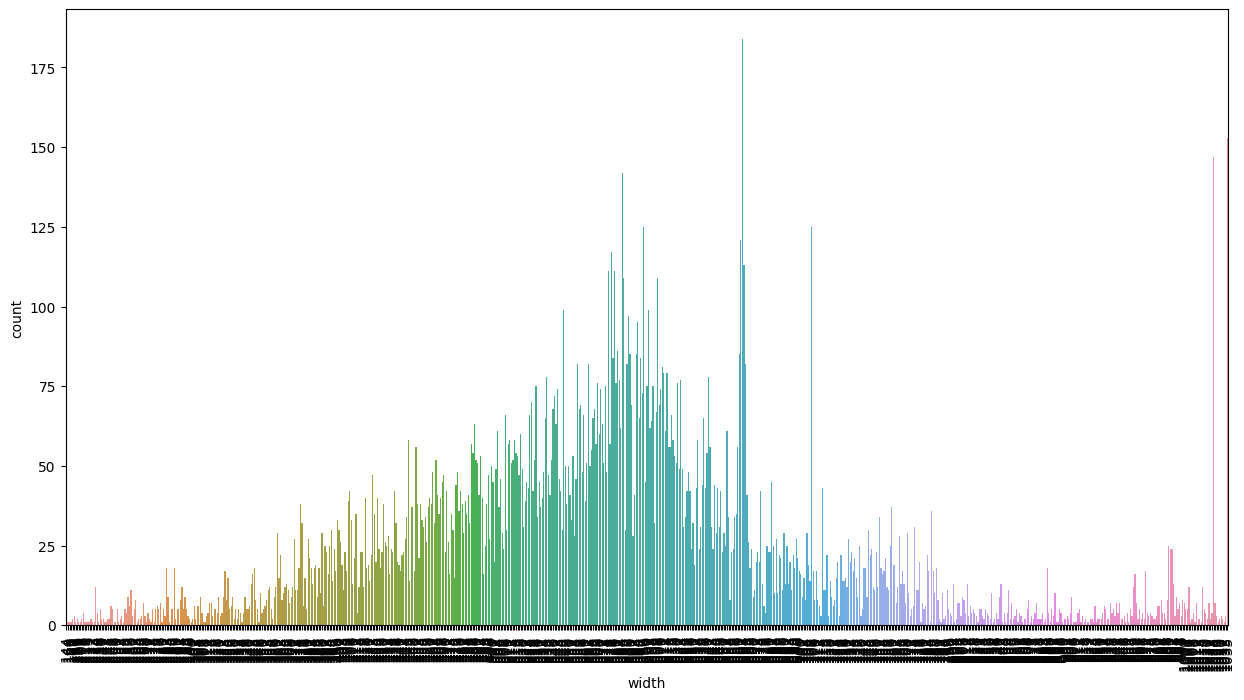

In [10]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(x='width', data=positive_img_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
None

#### Распределение по количеству различных значений высоты

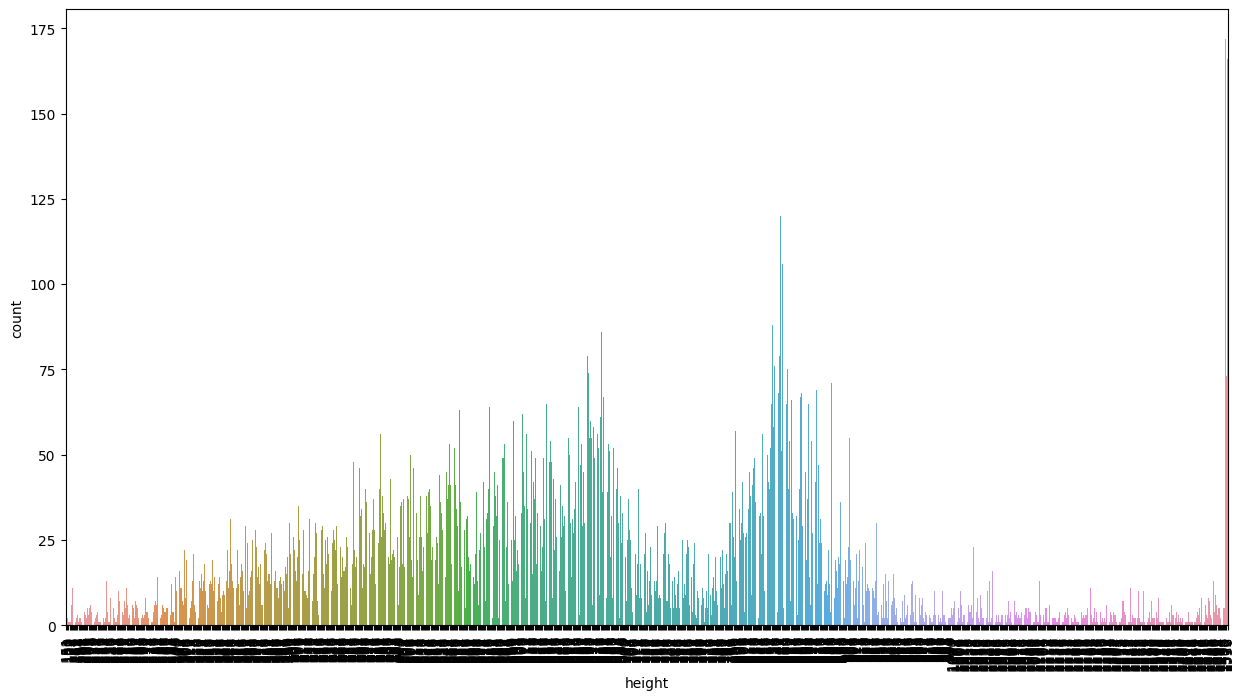

In [11]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(x='height', data=positive_img_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
None

#### Распределение по количеству различных значений ширины, распределенных по группам

In [12]:
def lvls_size(size, name_size):
    all_lvls_size_list = []
    lvl_140_250 = []
    lvl_250_350 = []
    lvl_350_450 = []
    lvl_450_550 = []
    lvl_550_650 = []
    lvl_650_750 = []
    lvl_750_850 = []
    lvl_850_950 = []
    lvl_950_1050 = []
    lvl_1050_1150 = []
    lvl_1150_1250 = []
    lvl_1250_1350 = []
    lvl_1350_1450 = []
    lvl_1450_1550 = []

    for i in size:
        if i >= 140 and i <= 250:
            lvl_140_250.append('140-250')
        elif i > 250 and i <= 350:
            lvl_250_350.append('250-350')
        elif i > 350 and i <= 450:
            lvl_350_450.append('350-450')
        elif i > 450 and i <= 550:
            lvl_450_550.append('450-550')
        elif i > 550 and i <= 650:
            lvl_550_650.append('550-650')
        elif i > 650 and i <= 750:
            lvl_650_750.append('650-750')
        elif i > 750 and i <= 850:
            lvl_750_850.append('750-850')
        elif i > 850 and i <= 950:
            lvl_850_950.append('850-950')
        elif i > 950 and i <= 1050:
            lvl_950_1050.append('950-1050')
        elif i > 1050 and i <= 1150:
            lvl_1050_1150.append('1050-1150')
        elif i > 1150 and i <= 1250:
            lvl_1150_1250.append('1150-1250')
        elif i > 1250 and i <= 1350:
            lvl_1250_1350.append('1250-1350')
        elif i > 1350 and i <= 1450:
            lvl_1350_1450.append('1350-1450')
        elif i > 1450 and i <= 1550:
            lvl_1450_1550.append('1450-1550')

    all_lvls_size_list.extend(lvl_140_250)
    all_lvls_size_list.extend(lvl_250_350)
    all_lvls_size_list.extend(lvl_350_450)
    all_lvls_size_list.extend(lvl_450_550)
    all_lvls_size_list.extend(lvl_550_650)
    all_lvls_size_list.extend(lvl_650_750)
    all_lvls_size_list.extend(lvl_750_850)
    all_lvls_size_list.extend(lvl_850_950)
    all_lvls_size_list.extend(lvl_950_1050)
    all_lvls_size_list.extend(lvl_1050_1150)
    all_lvls_size_list.extend(lvl_1150_1250)
    all_lvls_size_list.extend(lvl_1250_1350)
    all_lvls_size_list.extend(lvl_1350_1450)
    all_lvls_size_list.extend(lvl_1450_1550)

    df = pd.DataFrame(columns=[name_size], data=all_lvls_size_list)
    plt.figure(figsize=(15, 8))
    sns.countplot(x=name_size, data=df)

    return df

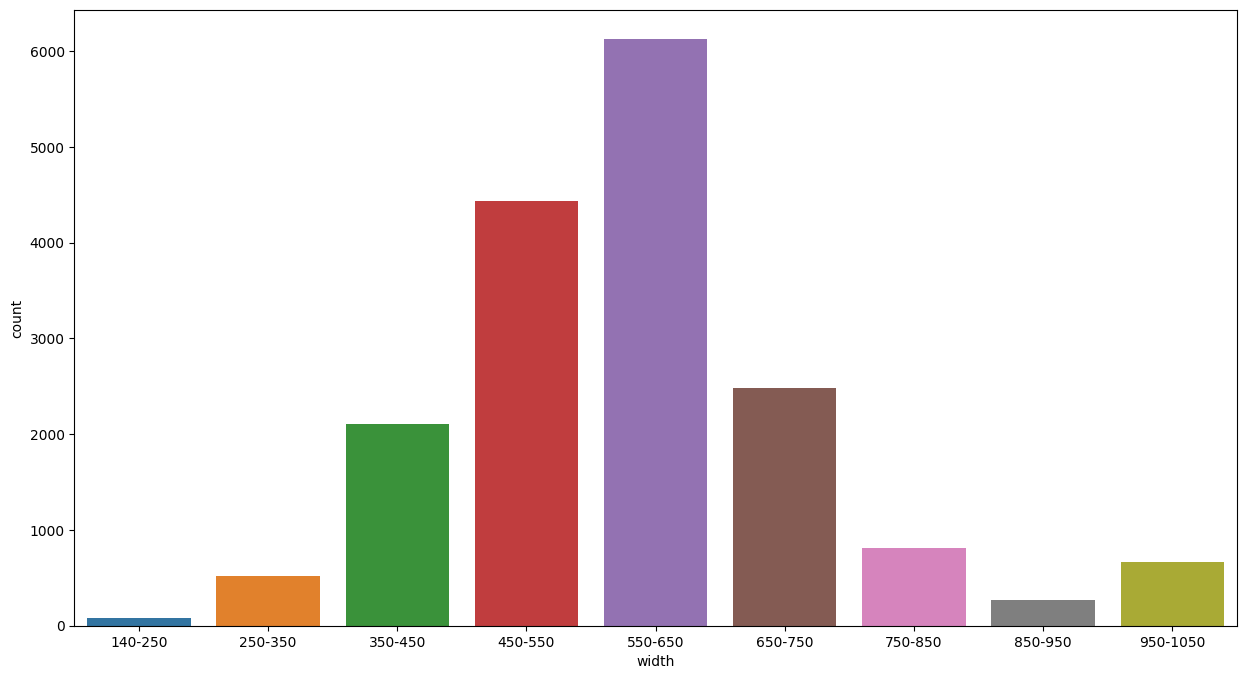

In [13]:
df_lvl_width = lvls_size(positive_img_df.width.to_list(), 'width')

#### Распределение по количеству различных значений высоты, распределенных по группам

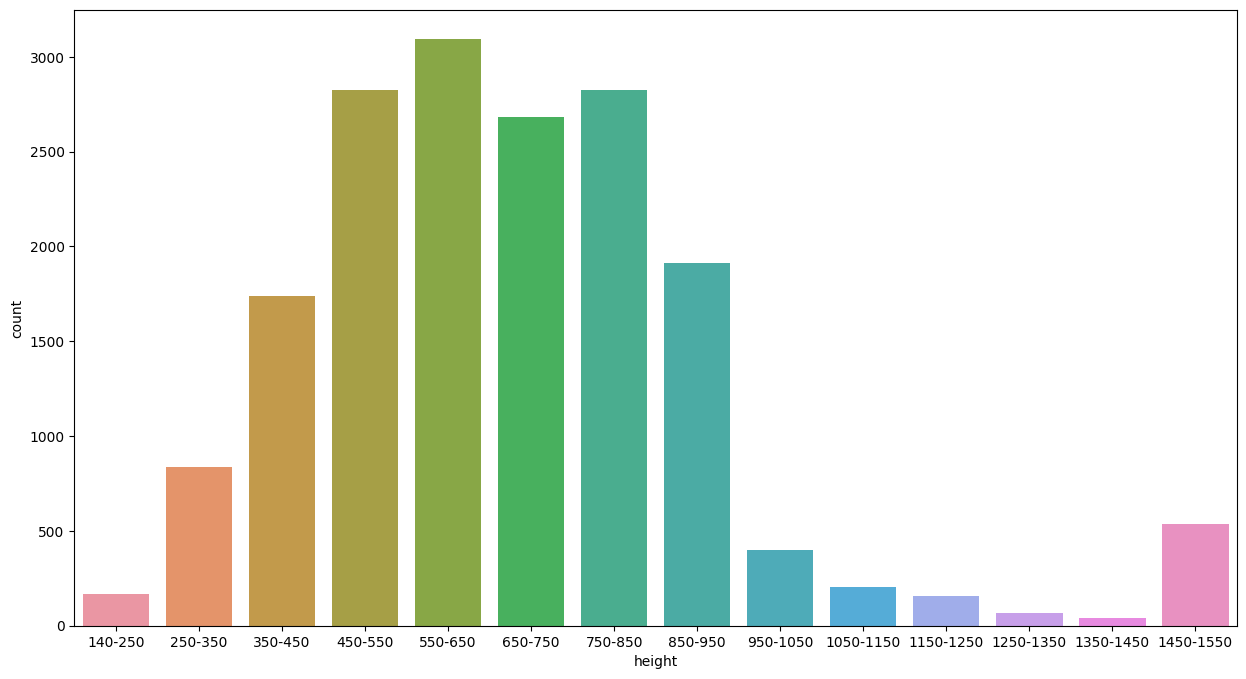

In [14]:
df_lvl_height = lvls_size(positive_img_df.height.to_list(), 'height')

#### Распределение по количеству различных значений ширины и высоты, распределенных по группам

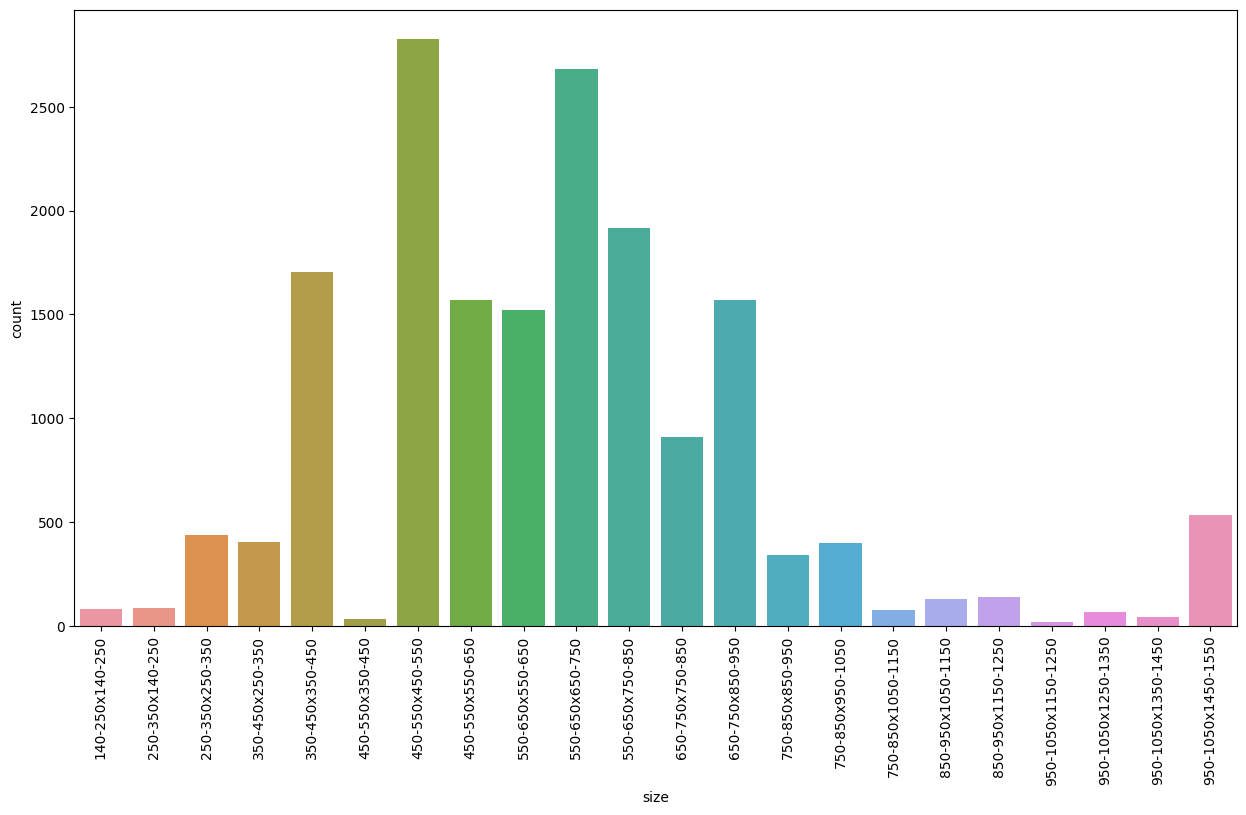

In [15]:
all_lvl_size_df = pd.merge(df_lvl_width, df_lvl_height, left_index=True, right_index=True)
all_lvl_size_df['size'] = all_lvl_size_df['width'].astype(str) + 'x' + all_lvl_size_df['height'].astype(str)

plt.figure(figsize=(15, 8))
ax = sns.countplot(x='size', data=all_lvl_size_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
None

## Проверка сбалансированности датасета

In [16]:
count_classes = positive_img_df['name_class'].value_counts()
print(f'Количество повторов категорий:\n{count_classes}\n\
Среднее по категориям: {count_classes.mean()}\n\
Медиана по категориям: {count_classes.median()}\n')

print(f"Сбалансированность датасета по сравнению с Pilers (самым большим классом) (%):\n\
Gun: {count_classes['Gun'] * 100 / count_classes['Pliers']}\n\
Wrench: {count_classes['Wrench'] * 100 / count_classes['Pliers']}\n\
Knife: {count_classes['Knife'] * 100 / count_classes['Pliers']}\n\
Scissors: {count_classes['Scissors'] * 100 / count_classes['Pliers']}\n")

print(f"Сбалансированность датасета по сравнению с общим кол-вом объектов (%):\n\
Pliers: {count_classes['Pliers'] * 100 / len(positive_img_df['images'])}\n\
Gun: {count_classes['Gun'] * 100 / len(positive_img_df['images'])}\n\
Wrench: {count_classes['Wrench'] * 100 / len(positive_img_df['images'])}\n\
Knife: {count_classes['Knife'] * 100 / len(positive_img_df['images'])}\n\
Scissors: {count_classes['Scissors'] * 100 / len(positive_img_df['images'])}\n")

Количество повторов категорий:
Pliers      5368
Gun         4863
Wrench      3076
Knife       3055
Scissors    1129
Name: name_class, dtype: int64
Среднее по категориям: 3498.2
Медиана по категориям: 3076.0

Сбалансированность датасета по сравнению с Pilers (самым большим классом) (%):
Gun: 90.59239940387481
Wrench: 57.30253353204173
Knife: 56.91132637853949
Scissors: 21.03204172876304

Сбалансированность датасета по сравнению с общим кол-вом объектов (%):
Pliers: 30.690069178434623
Gun: 27.802870047452977
Wrench: 17.586187181979305
Knife: 17.466125435938483
Scissors: 6.454748156194614



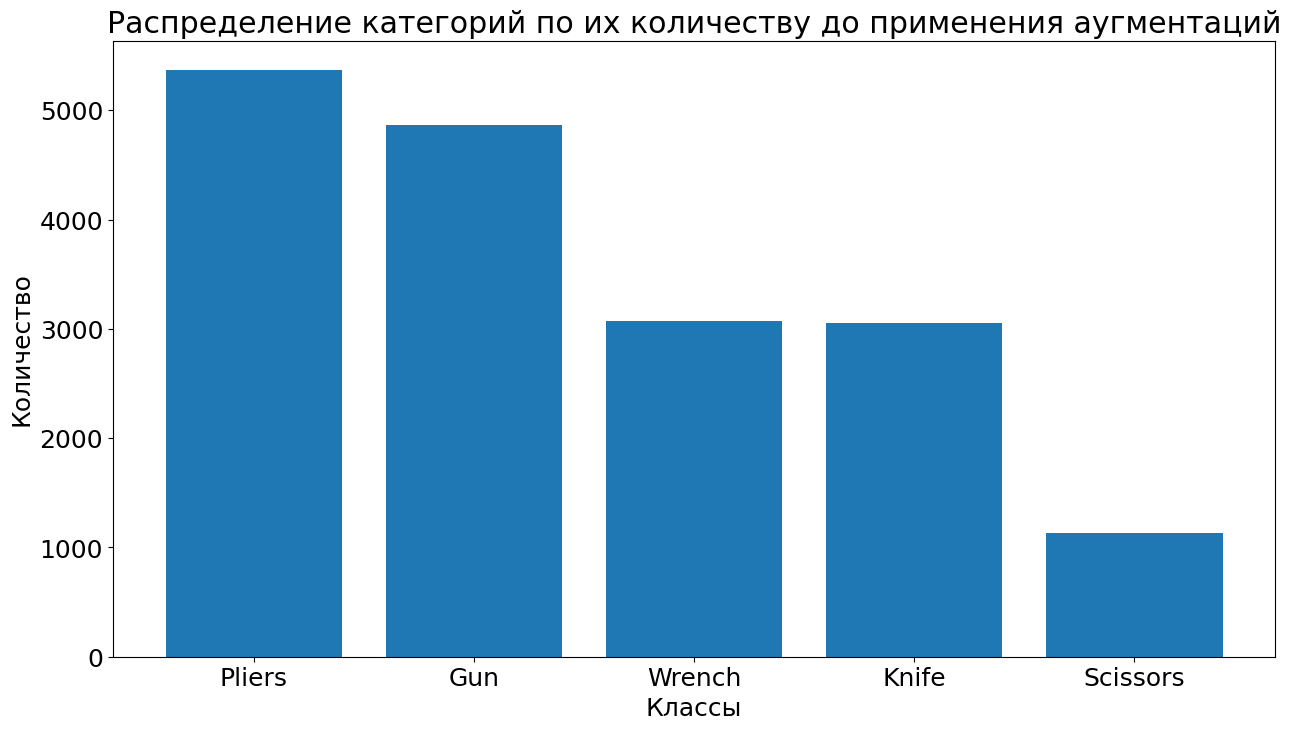

In [17]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(15, 8))
vals_counts = positive_img_df['name_class'].value_counts().to_dict()
plt.bar(list(vals_counts.keys()), list(vals_counts.values()))
plt.ylabel('Количество')
plt.xlabel('Классы')
plt.title('Распределение категорий по их количеству до применения аугментаций')
None